In [48]:
%matplotlib inline

import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import copy
import pandas as pd
from sklearn.utils import shuffle
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset


use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


In [49]:
path2data = '/home/r120084/data/'

In [50]:
path2trainData = path2data + 'train/training.csv'
path2testData = path2data + 'test/test.csv'

In [51]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, path2data, val_size = 0.1, dropnan = True, transforms=None, is_valid=False,
                 is_test=False, is_train = False):
        
        
        self.transform = transforms    
        self.df = pd.read_csv(path2data)
        if dropnan:
             self.drop_nan()
                 
        self.df['Image'] = self.df['Image'].apply(lambda im: self.get_image(im))
        self.X = self.get_X()
        
        if ( (is_train) or (is_valid)):
            self.get_train_target() 
            if is_valid:
                self.split_data(val_size)
            self.normalize_target()
            
        if is_test:
            self.get_X()
            self.get_test_target()
                 
    def normalize_target(self):
        self.y = (self.y- self.y.max()) /self.y.max()
        self.y = self.y.astype(np.float32)
 
    def _show_keys(self):
         print(self.df.dtypes)

    def get_image(self, x):
        x = np.fromstring(x, sep = ' ')
        return x

    def drop_nan(self):
        self.df = self.df.dropna()

    def get_X(self):

        X = np.vstack(self.df['Image'].values) / 255.  # scale pixel values to [0, 1]
        X = X.astype(np.float32)
        X = X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96
        return X

    def get_train_target(self):

        self.y = self.df[self.df.columns[:-1]].values

    def get_test_target(self):
        self.y = None

    def split_data(self, val_size = 0.1):

        np.random.seed(4572)
        indices = range(len(self.X))

        ind = np.random.permutation(indices)
        split = np.round(val_size * len(self.X))
        index= np.array(ind[:split])
        
        self.X = self.X.take(index,axis=0)
        self.y = self.y.take(index,axis=0)
    
    def __getitem__(self, index):
        image = self.X[index]
        if self.transform is not None:
            image = self.transform(image)
        label = self.y[index]
        return image, label
    
    def __str__(self):
        print('Dataset size is {}'.format(self.df.shape))

In [52]:
batch_size = 32

In [53]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

dsets = {
    'train': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['train'], is_train = True),
    'valid': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['valid'], is_valid=True, val_size=0.2),
    'test':  FaceKeyPointsDataset(path2testData, transforms=data_transforms['valid'], is_test=True),
}

dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False),
    'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False),
}

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [54]:
dsets['train']._show_keys()

left_eye_center_x            float64
left_eye_center_y            float64
right_eye_center_x           float64
right_eye_center_y           float64
left_eye_inner_corner_x      float64
left_eye_inner_corner_y      float64
left_eye_outer_corner_x      float64
left_eye_outer_corner_y      float64
right_eye_inner_corner_x     float64
right_eye_inner_corner_y     float64
right_eye_outer_corner_x     float64
right_eye_outer_corner_y     float64
left_eyebrow_inner_end_x     float64
left_eyebrow_inner_end_y     float64
left_eyebrow_outer_end_x     float64
left_eyebrow_outer_end_y     float64
right_eyebrow_inner_end_x    float64
right_eyebrow_inner_end_y    float64
right_eyebrow_outer_end_x    float64
right_eyebrow_outer_end_y    float64
nose_tip_x                   float64
nose_tip_y                   float64
mouth_left_corner_x          float64
mouth_left_corner_y          float64
mouth_right_corner_x         float64
mouth_right_corner_y         float64
mouth_center_top_lip_x       float64
m

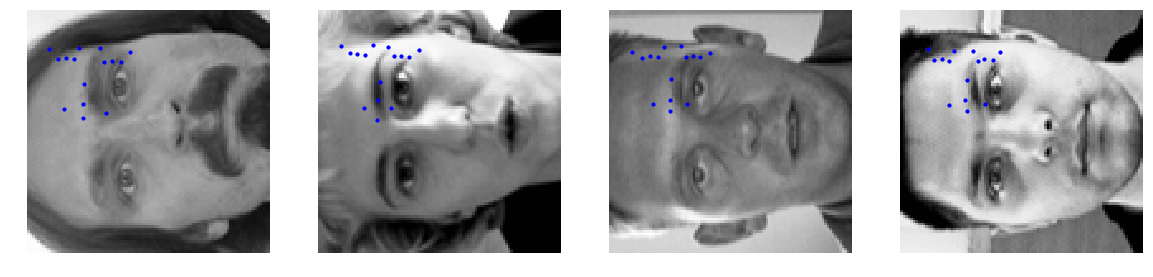

In [55]:
plt.figure(figsize=(20,5))
for i in range(0, 4):
    plt.subplot(1,4,i+1)
    X = dsets['train'][i][0].numpy()
    img = X.reshape(96,96)
    y =  dsets['train'][i][1]
    cordinates = y* 48 + 48
    plt.imshow(img, cmap = 'gray')
    plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
    plt.axis('off')

In [56]:
nb_out = 15

In [63]:
class myconvNet(nn.Module):

    def __init__(self, image_size=(1,96,96)):
        super(myconvNet, self).__init__()
        self.conv1 = nn.Conv2d(image_size[0], 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        feature_size = self._get_conv_output(image_size)
        
        self.fc1 = nn.Linear(feature_size, 250)        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, nb_out)

        
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc3(x))
        return x
    
    
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))       
        return x
    
    
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

In [64]:
myconvNet = myconvNet()
if use_gpu:
    myconvNet = myconvNet.cuda()

In [65]:
print(myconvNet)

myconvNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (30976 -> 250)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 15)
)
